In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import collections
import re
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:

with open("LabelledData.txt","r") as text:
    lines=text.readlines()
lines=[line.replace("\n","") for line in lines]
lines=[line.split(",,,") for line in lines]
questions=[line[0] for line in lines]
question_type=[line[1] for line in lines]
question_type=[q.strip() for q in question_type]
questions=[q.strip() for q in questions]
lines=[[q,w] for (q,w) in zip(questions,question_type)]
data=pd.DataFrame(lines,columns=["Question","Question_Type"])
data.head()


,Question,Question_Type
0,how did serfdom develop in and then leave russ...,unknown
1,what films featured the character popeye doyle ?,what
2,how can i find a list of celebrities ' real na...,unknown
3,what fowl grabs the spotlight after the chines...,what
4,what is the full form of .com ?,what


We have a set of questions,assigned to a specific question type. The question types are as follows:


In [3]:
question_types=np.unique(data["Question_Type"].values,return_counts=True)
print question_types

(array(['affirmation', 'unknown', 'what', 'when', 'who'], dtype=object), array([104, 272, 609,  96, 402], dtype=int64))


All the classes seems adequately presented, however questions of type "what" are over represented in data. Let us visualize it
better using a plot.

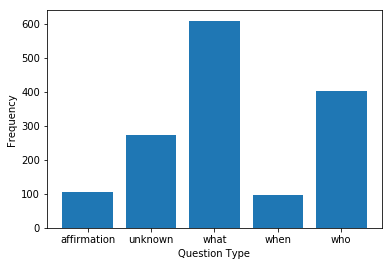

In [4]:
plt.bar(range(len(list(question_types[0]))),list(question_types[1]))
plt.xlabel("Question Type")
plt.ylabel("Frequency")
plt.xticks(range(len(list(question_types[0]))),list(question_types[0]))
plt.show()

Let's set baselines. We will only use one baseline here and then try further models. The baseline is to predict "What" for every
example. This gives us an accuracy of: 

In [5]:
count=collections.Counter(data["Question_Type"].values)
print count["what"]/float(len(data))

0.410654079568


So, we can see without much surprise that we are doing quite a bad job. So it is better to try learning based models. We will
build a MaxEnt model for this exercise. But before that,we need to normalize our text data so as to not have redundant representations. 


In [6]:
def data_processing(text):
    puncts=[',',"'",'"']
    stemmer=SnowballStemmer("english")
    processed_text=[]
    for line in text:
        line=line.lower()
        line=line.decode('utf-8','ignore')
        line=re.sub(r'[0-9]+','',line)
        
        words=nltk.word_tokenize(line)
        words=[w for w in words if w not in puncts]
        words=[stemmer.stem(w) for w in words]
        processed_text.append(" ".join(words))
     
    return processed_text
        
    

In [7]:
processed_text=data_processing(data["Question"].values)
cv=CountVectorizer()
tf=TfidfTransformer()

cv_data=cv.fit_transform(processed_text)
tf_data=tf.fit_transform(cv_data).toarray()
tf_df=pd.DataFrame(tf_data,columns=cv.get_feature_names())
tf_df.head()

,abbi,abbrevi,abil,abolish,abomin,about,academi,accept,access,accessori,...,your,yous,yousuf,zadora,zealand,zenger,zodiac,zolotow,zone,zorro
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we can see, the feature matrix is very sparse an workin with it is not a really good idea on account of the curse of dimensionality.Let us try to fit a MaxEnt model on this before going further with any other thing.

In [8]:
label_dict={'who':1,"what":2,"when":3,"affirmation":4,"unknown":5}
y=[label_dict[t] for t in data["Question_Type"].values]
Xtrain,Xtest,ytrain,ytest=train_test_split(tf_df.values,y,test_size=0.20)

In [9]:
def train(X,y,algorithm="Logistic"):
    if(algorithm=="Logistic"):
        clf=LogisticRegression(penalty='l2',C=10,multi_class="multinomial",solver="newton-cg")
        clf.fit(X,y)
    return clf
model=train(Xtrain,ytrain)
print(model.score(Xtrain,ytrain))
print(model.score(Xtest,ytest))

1.0
0.959595959596


From the results, it might seem like we are overfitting on the model but we can't be sure as the test set is really small, so is
the training set.

In [10]:
#Let us write a predicct function to see how we are doing on some data
def predict(question,label_dict=label_dict,clf=model,cv=cv,tf=tf):
    question=data_processing([question])
    
    cv_vector=cv.transform(question)
    tf_vector=tf.transform(cv_vector).toarray()
    pred=clf.predict(tf_vector)
    return [key for key in label_dict.keys() if label_dict[key]==pred][0]


In [11]:
#Some testing sentences:
sents=["what time does the movie begin?","what is the birthplace of john?","Who was gandhi","Is it morning or noon?",
      "are you a smuggler?","what time does the train leave?","what is the time?"]
for sent in sents:
    print sent,predict(sent)

what time does the movie begin? when
what is the birthplace of john? what
Who was gandhi who
Is it morning or noon? affirmation
are you a smuggler? affirmation
what time does the train leave? when
what is the time? what


They seem to be working well, let us use a larger testing corpus. Since our dataset was approximately a 1000 sentences, lets 
sample 200 sentences from  http://cogcomp.cs.illinois.edu/Data/QA/QC/train_1000.label

In [107]:
#Loading the testing data:
with open('train_1000.label.txt','r') as filename:
    lines=filename.readlines()
test_labels=[]
test_sents=[]
for line in lines:
    line=line.lstrip()
    line=line.rstrip()
    line=line.replace("\n","")
    words=line.split()
   
    test_labels.append(words[0])
    test_sents.append(" ".join(words[1:]))

#Now lets randomly sample 200 sentences from the dataset:
test_indices=np.random.permutation(len(test_sents))[:200]

labels=[test_labels[ind] for ind in test_indices]
sents=[test_sents[ind] for ind in test_indices]

#Lets print predictions for first ten sentences:
for i,sent in enumerate(sents):
    print sent,predict(sent),labels[i]
    if(i==10):
        break

How can I get some free technical information on Electric Vehicle ? unknown DESC:manner
What is the daily requirement of folic acid for an expectant mother ? what DESC:desc
What was American folk hero John Chapman 's nickname ? what HUM:ind
What is a female rabbit called ? what ENTY:animal
What was the U.S. highway death toll in 1969 ? what NUM:count
What Nevada center has been dubbed The Biggest Little City in the World ? what LOC:city
When did Mount St. Helen last have a significant eruption ? when NUM:date
What Spanish artist painted Crucifixion ? what HUM:ind
How many species of sharks are there ? unknown NUM:count
Where on the Internet can I get information about the Fifth Amendment on the American Bill of Rights ? unknown LOC:other
Who coined the term NN cyberspace `` in his novel NN Neuromancer '' ? who HUM:ind


As you can see from the predictions, that we are doing reasonably well in our predictions. The l2 regularizaion is penalizing 
terms so we don't really need to subsample features, as it will probably degrade performance than improve it.

In [108]:
import os
os.listdir('./')

['.ipynb_checkpoints',
 'LabelledData.txt',
 'Notebook.ipynb',
 'QuestionClassifier.py',
 'train_1000.label.txt']